In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import cv2
from torchvision import models, transforms
from timm.models.vision_transformer import vit_large_patch16_384
from timm.models import create_model, resume_checkpoint, convert_splitbn_model
print("done")

# from ...code.gao_deit.stu_acs.models import models
# from ...code.gao_deit.stu_acs.cait_models import cait_models
# os.system("pwd")
import cait_models
import models

done


In [2]:
stu_PATH = "/home/users/gaoshiyu01/code/gao_deit/stu_acs/output/checkpoint299.pth"
stu_name = 'deit_tiny_distilled_patch16_224'
stu_model = create_model(
        stu_name,
        pretrained=False,
        num_classes=1000,
        drop_rate=0.0,
        drop_path_rate=0.1,
        drop_block_rate=None,
    )
checkpoint = torch.load(stu_PATH)
checkpoint_no_module_stu = {}
for k in stu_model.state_dict().keys():
    checkpoint_no_module_stu[k] = checkpoint["model"][k]
stu_model.load_state_dict(checkpoint_no_module_stu)
print("done")

done


In [3]:
tea_PATH = "/home/users/gaoshiyu01/code/gao_deit/align_attn_test/S24_224.pth"
tea_name = 'cait_S24_224'
teacher_model = create_model(
            tea_name,
            pretrained=False,
            num_classes=1000,
            global_pool='avg',
        )
checkpoint = torch.load(tea_PATH)
checkpoint_no_module = {}
for k in teacher_model.state_dict().keys():
    checkpoint_no_module[k] = checkpoint["model"]['module.'+k]
teacher_model.load_state_dict(checkpoint_no_module)
print("done")

done


In [4]:
block_weights = [] # we will save the conv layer weights in this list
block_layers = [] # we will save the 49 conv layers in this list
tea_model_children = list(teacher_model.children()) # get all the model children as list
stu_model_children = list(stu_model.children())

In [5]:
tea_all_block = []  # put all sub block in the list
for model_child in list(teacher_model.children()):
    if type(model_child) != torch.nn.modules.container.ModuleList:
        tea_all_block.append(model_child)
    else:
        sub_children = list(model_child.children())
        for sub_child in sub_children:
            tea_all_block.append(sub_child)
# print(len(tea_all_block))

In [6]:
stu_all_block = []  # put all sub block in the list
for model_child in list(stu_model.children()):
    if type(model_child) != torch.nn.modules.container.ModuleList:
        stu_all_block.append(model_child)
    else:
        sub_children = list(model_child.children())
        for sub_child in sub_children:
            stu_all_block.append(sub_child)
# print(len(stu_all_block))
# print(stu_all_block[0])

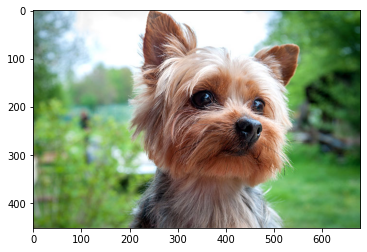

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [7]:
# read and visualize an image
img = cv2.imread("./dog.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),  # reszie the image as (1024, 1024) or (2048, 2048) to obtain high resolution features if you have large CPU or GPU memory
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [8]:
# pass the image through all the layers
stu_results = []
stu_results = [stu_all_block[0](img)]
for i in range(1, len(stu_all_block)-2):
    # pass the result from the last layer to the next layer
    stu_results.append(stu_all_block[i](stu_results[-1]))
# make a copy of the `results`
stu_outputs = stu_results

Saving layer 0 feature maps...


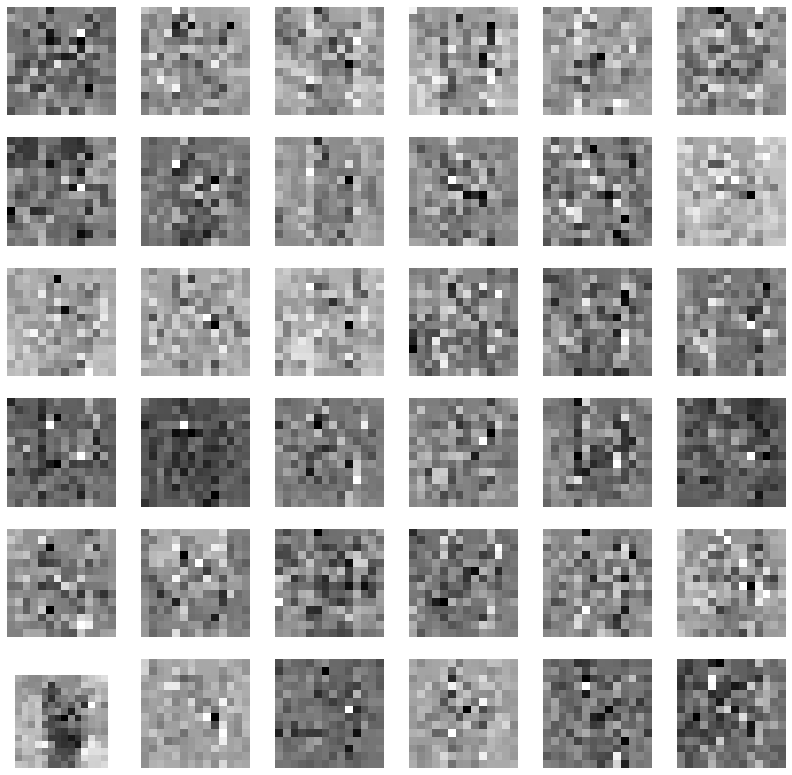

Saving layer 1 feature maps...


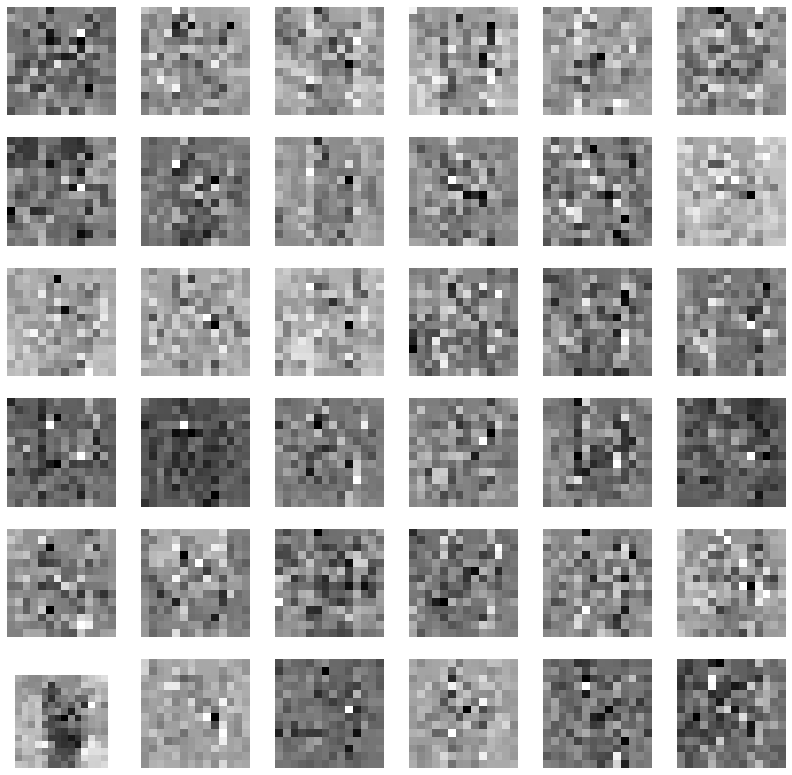

Saving layer 2 feature maps...


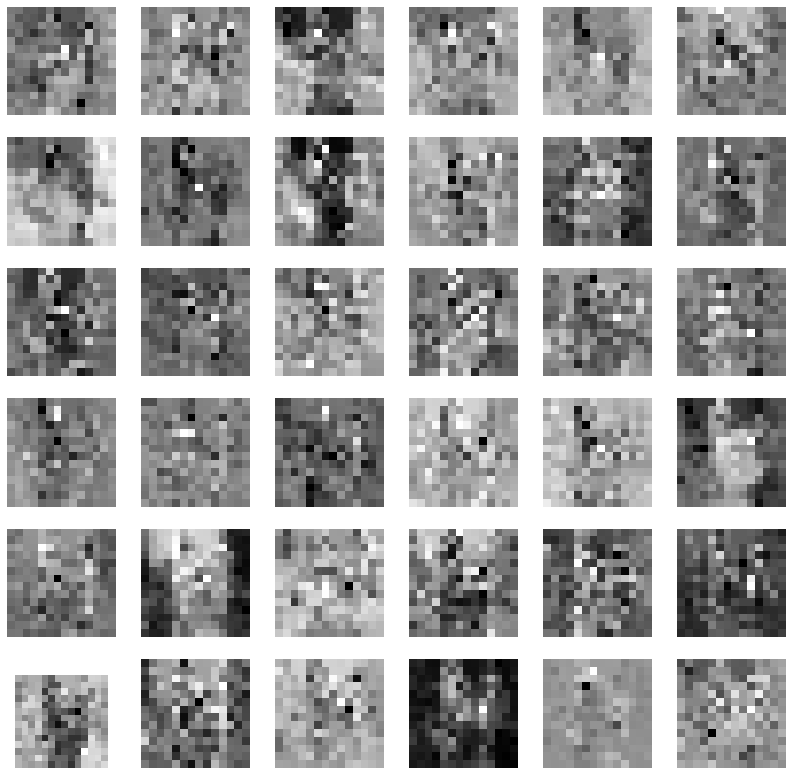

Saving layer 3 feature maps...


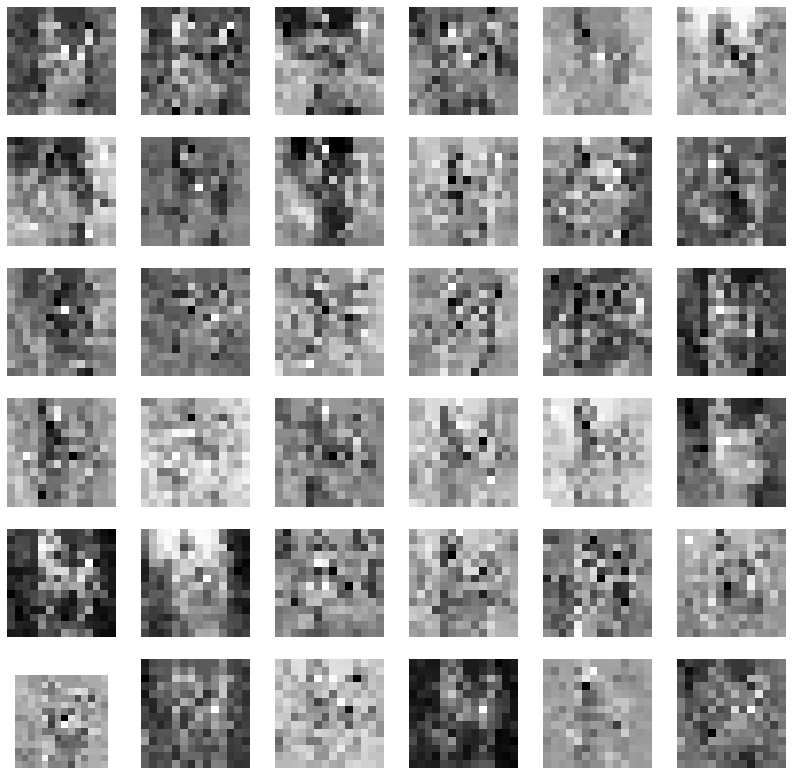

Saving layer 4 feature maps...


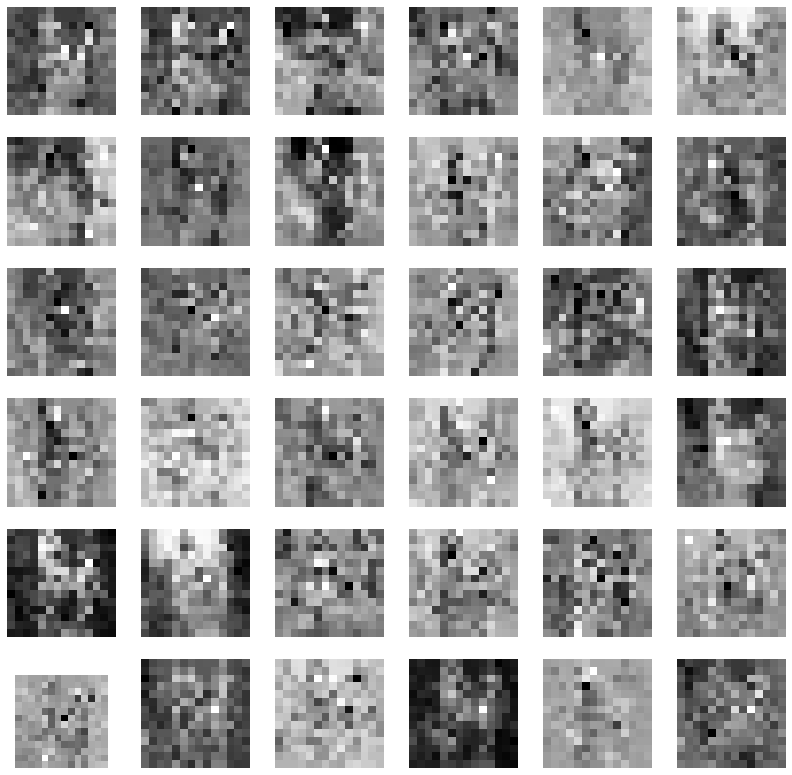

In [16]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 5   # change the number of length to control how many layers you want to visualize
head_num = 3
for num_layer in range(all_layers_num): 
    plt.figure(figsize=(14, 14))
    layer_viz = stu_outputs[num_layer]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = torch.nn.functional.normalize(layer_viz,dim=1)
    layer_viz = layer_viz.reshape(192, 14, 14)  # chage the reshape here
#     layer_viz = layer_viz.view(head_num, 192//head_num, 14, 14)
#     channel_attn = torch.nn.functional.normalize(channel_attn,dim=2)
    channel_attn = layer_viz.mean(0)
    #print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 36: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(6, 6, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")

    plt.subplot(7, 6, 37)
    plt.imshow(channel_attn, cmap='gray')
    plt.axis("off")
    
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig("./visul_fig/stu_layer_{}.png".format(num_layer))  # change the path to save the feature maps
    plt.show() # use this line to show the figure in jupyter notebook
    plt.close()

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

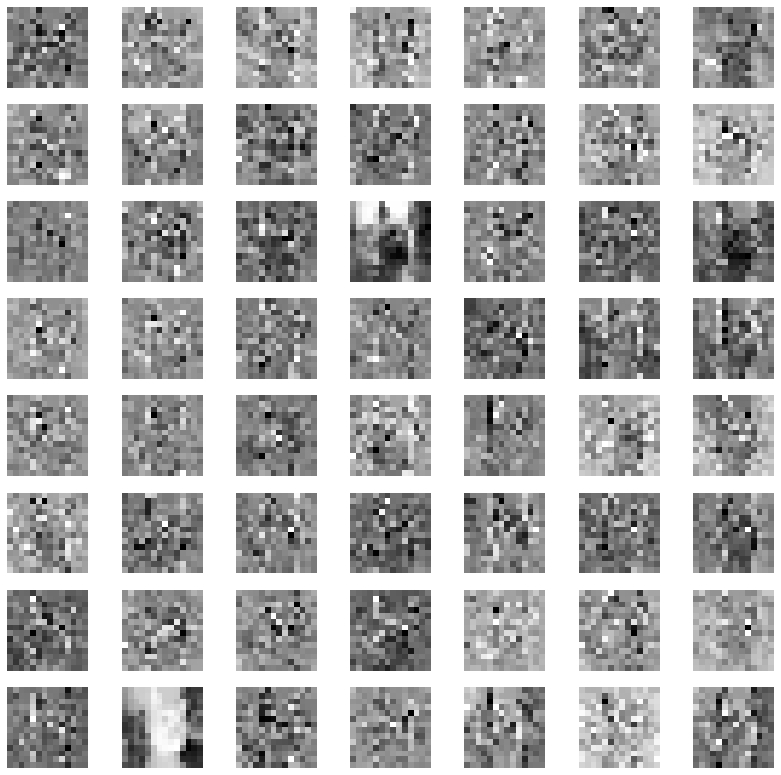

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

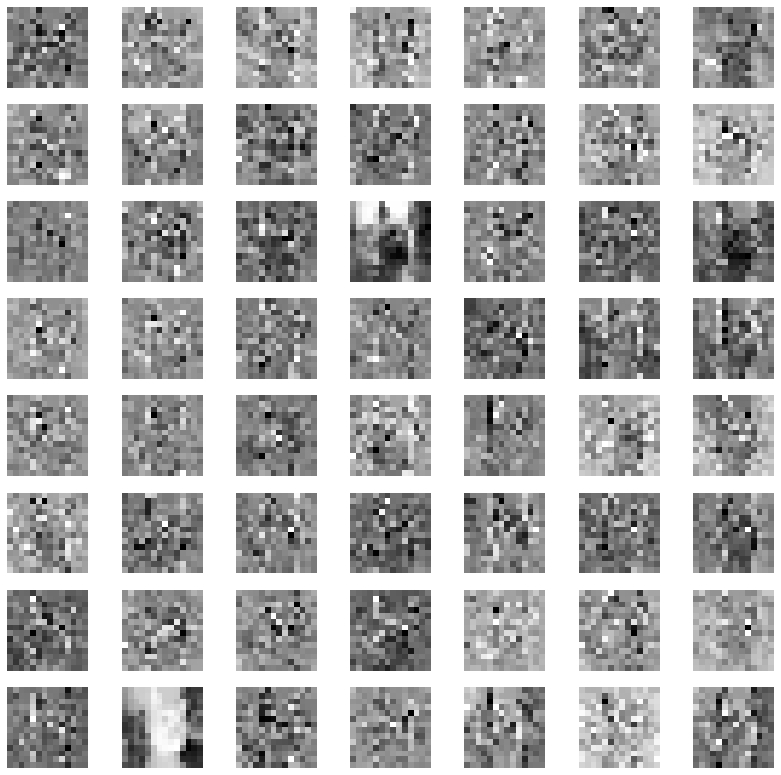

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

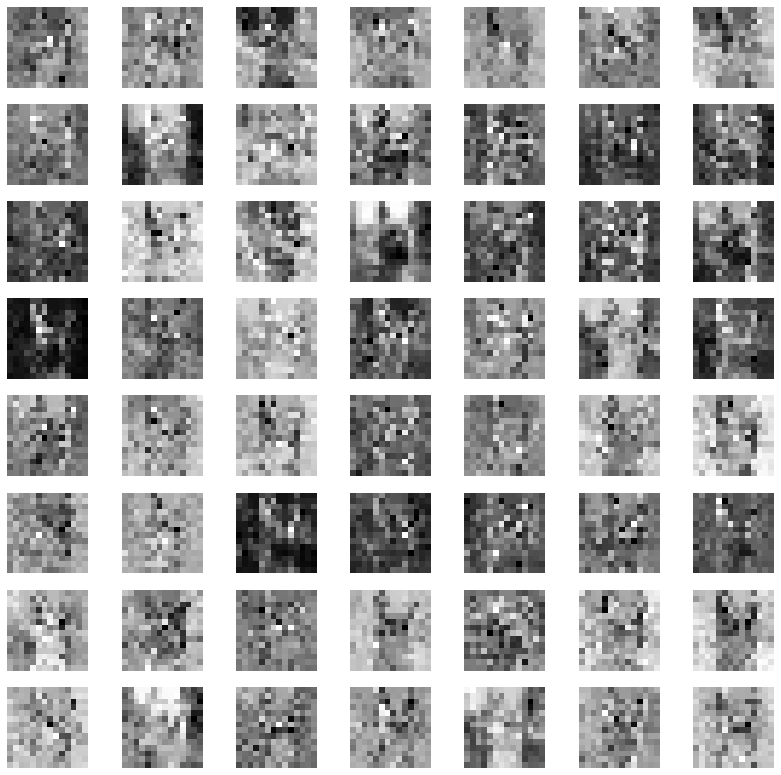

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

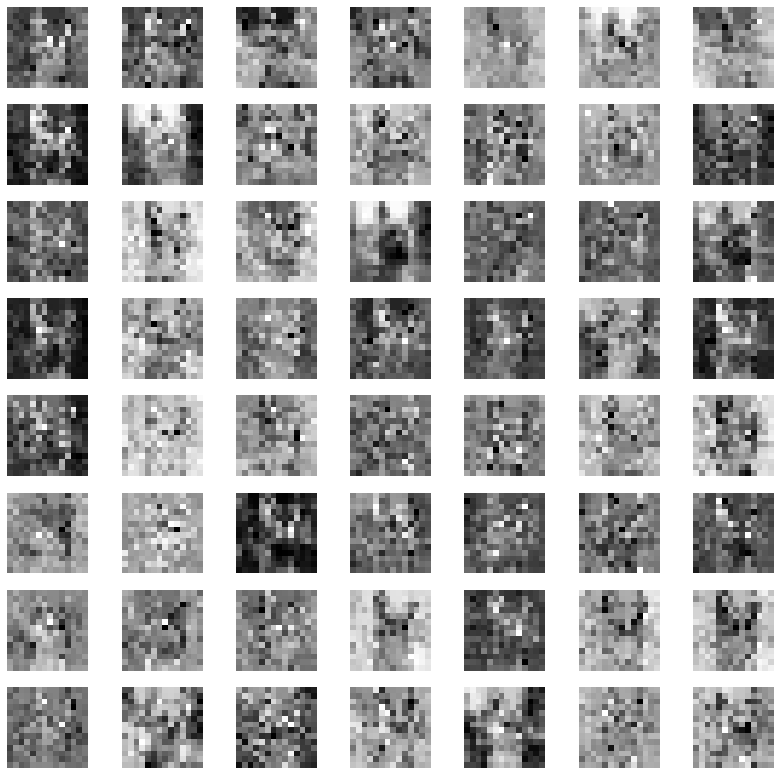

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

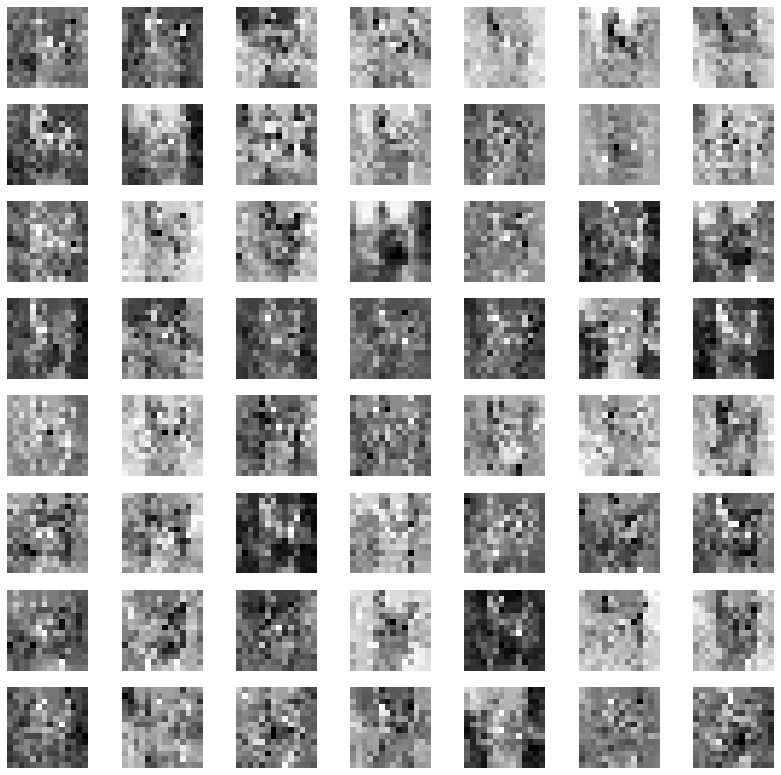

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

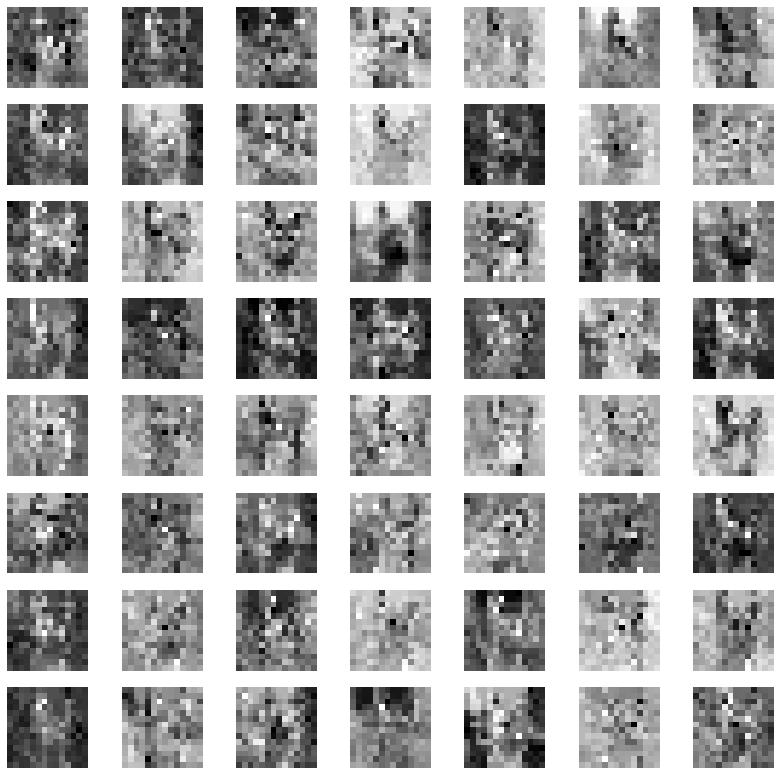

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

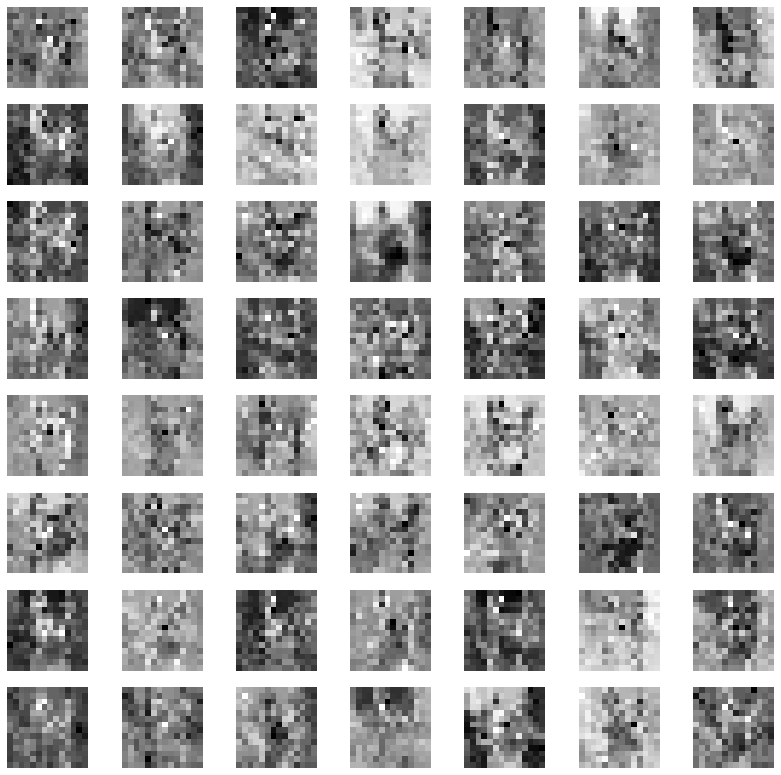

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

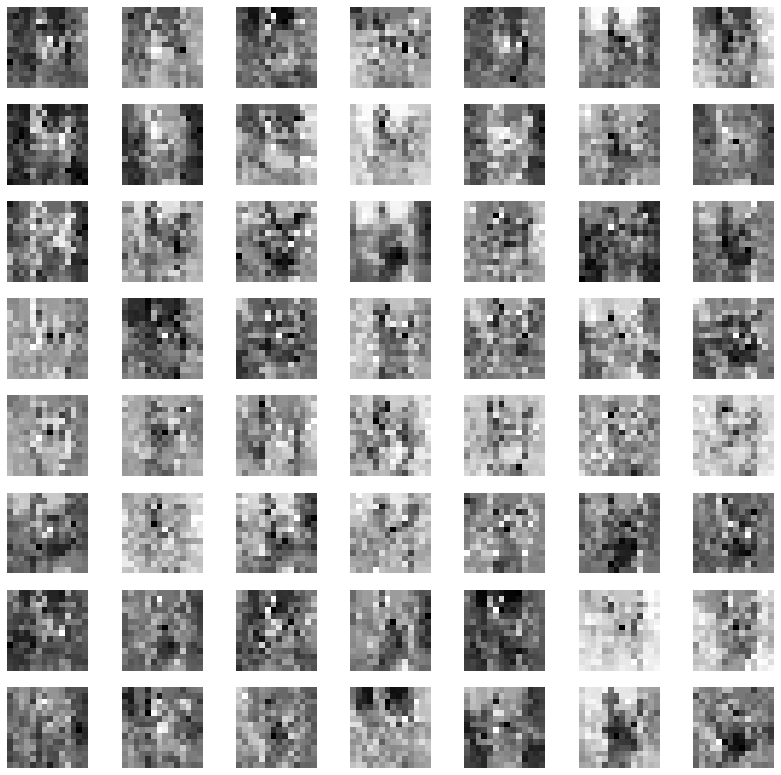

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

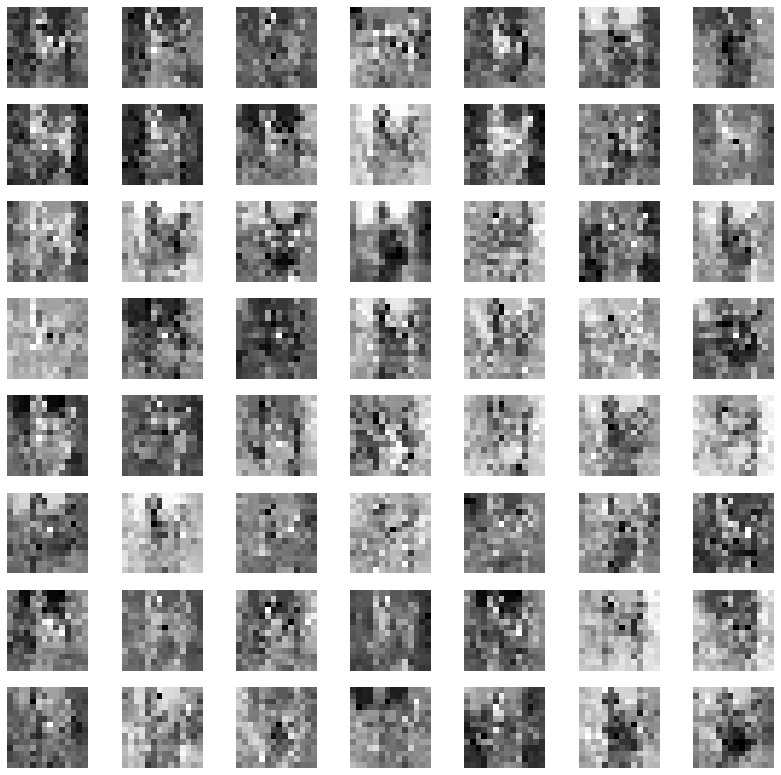

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

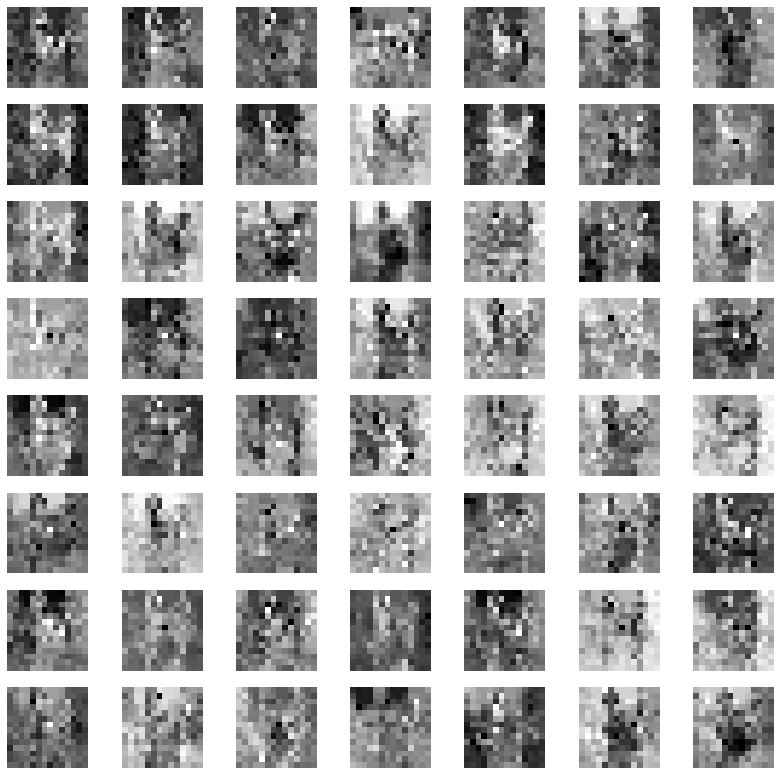

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

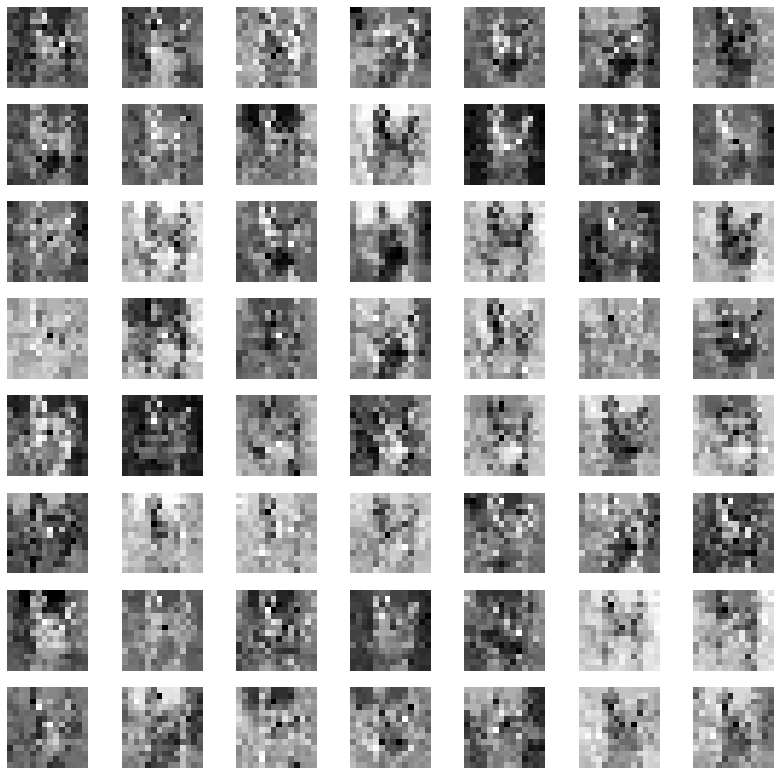

torch.Size([8, 14, 14])
torch.Size([192, 14, 14])
0 0 0
0 0 0
0 1 1
0 1 1
0 2 2
0 2 2
0 3 3
0 3 3
0 4 4
0 4 4
0 5 5
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
1 0 24
1 0 24
1 1 25
1 1 25
1 2 26
1 2 26
1 3 27
1 3 27
1 4 28
1 4 28
1 5 29
1 5 29
1 6 30
1 7 31
1 8 32
1 9 33
1 10 34
1 11 35
1 12 36
1 13 37
1 14 38
1 15 39
1 16 40
1 17 41
1 18 42
1 19 43
1 20 44
1 21 45
1 22 46
1 23 47
2 0 48
2 0 48
2 1 49
2 1 49
2 2 50
2 2 50
2 3 51
2 3 51
2 4 52
2 4 52
2 5 53
2 5 53
2 6 54
2 7 55
2 8 56
2 9 57
2 10 58
2 11 59
2 12 60
2 13 61
2 14 62
2 15 63
2 16 64
2 17 65
2 18 66
2 19 67
2 20 68
2 21 69
2 22 70
2 23 71
3 0 72
3 0 72
3 1 73
3 1 73
3 2 74
3 2 74
3 3 75
3 3 75
3 4 76
3 4 76
3 5 77
3 5 77
3 6 78
3 7 79
3 8 80
3 9 81
3 10 82
3 11 83
3 12 84
3 13 85
3 14 86
3 15 87
3 16 88
3 17 89
3 18 90
3 19 91
3 20 92
3 21 93
3 22 94
3 23 95
4 0 96
4 0 96
4 1 97
4 1 97
4 2 98
4 2 98
4 3 99
4 3 99
4 4 100
4 4 10

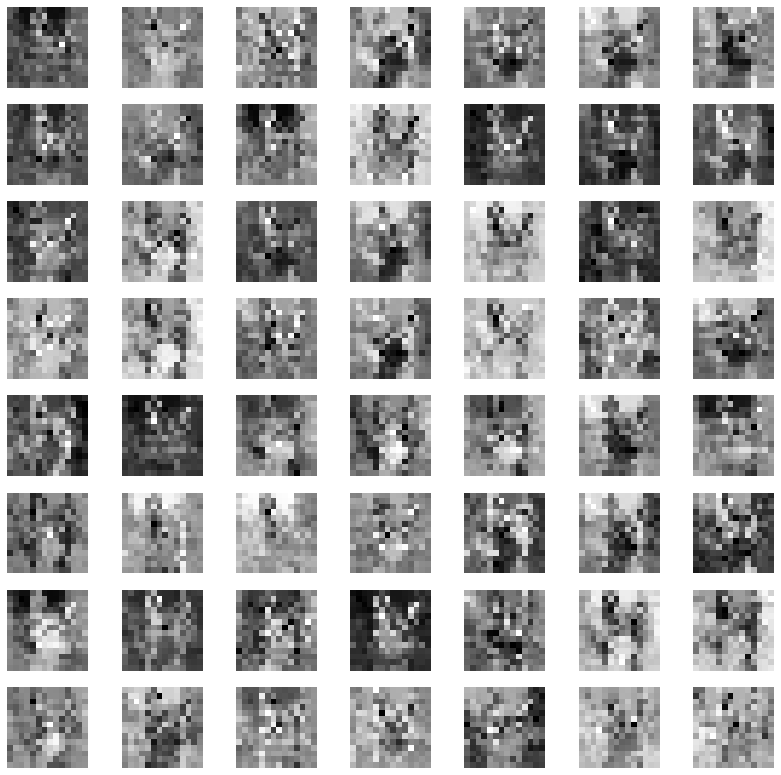

In [50]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 12   # change the number of length to control how many layers you want to visualize
head_num = 8
head_dim = 24
for num_layer in range(all_layers_num): 
    plt.figure(figsize=(14, 14))
    layer_viz = stu_outputs[num_layer]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = layer_viz.reshape(192, 14, 14)  # chage the reshape here
    channel_attn = layer_viz.reshape(head_num, 192//head_num, 14, 14)
    channel_attn = channel_attn.mean(1)
    print(channel_attn.size())
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 192: # we will visualize only 8x8 blocks from each layer
            break
        j = int(i//head_dim)
        k = i % head_dim
        print(j,k,i)
        if k < 6:
            print(j,k,i)
            plt.subplot(head_num, 7, j*7+k+1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
            if k==5:
                head_attn = channel_attn[j]
                plt.subplot(head_num, 7, (j+1)*7)
                plt.imshow(head_attn, cmap='gray')
                plt.axis("off")

#     plt.subplot(7, 6, 37)
#     plt.imshow(channel_attn, cmap='gray')
#     plt.axis("off")
    
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig("./visul_fig/stu_layer_{}.png".format(num_layer))  # change the path to save the feature maps
    plt.show() # use this line to show the figure in jupyter notebook
    plt.close()

In [10]:
# pass the image through all the layers
tea_results = []
tea_results = [tea_all_block[0](img)]
for i in range(1, len(tea_all_block)-4):
    # pass the result from the last layer to the next layer
    tea_results.append(tea_all_block[i](tea_results[-1]))
# make a copy of the `results`
tea_outputs = tea_results


Saving layer 0 feature maps...


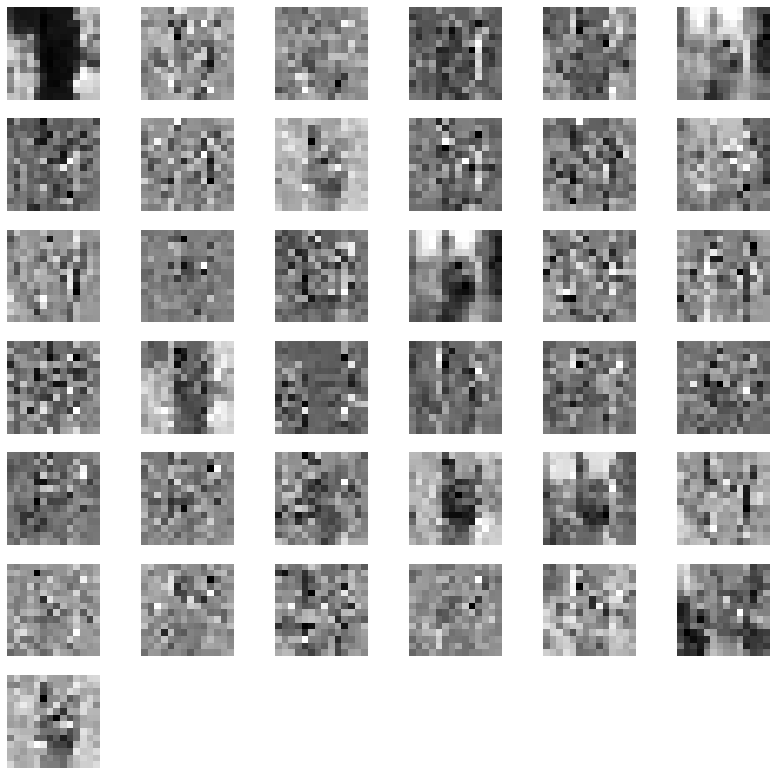

Saving layer 1 feature maps...


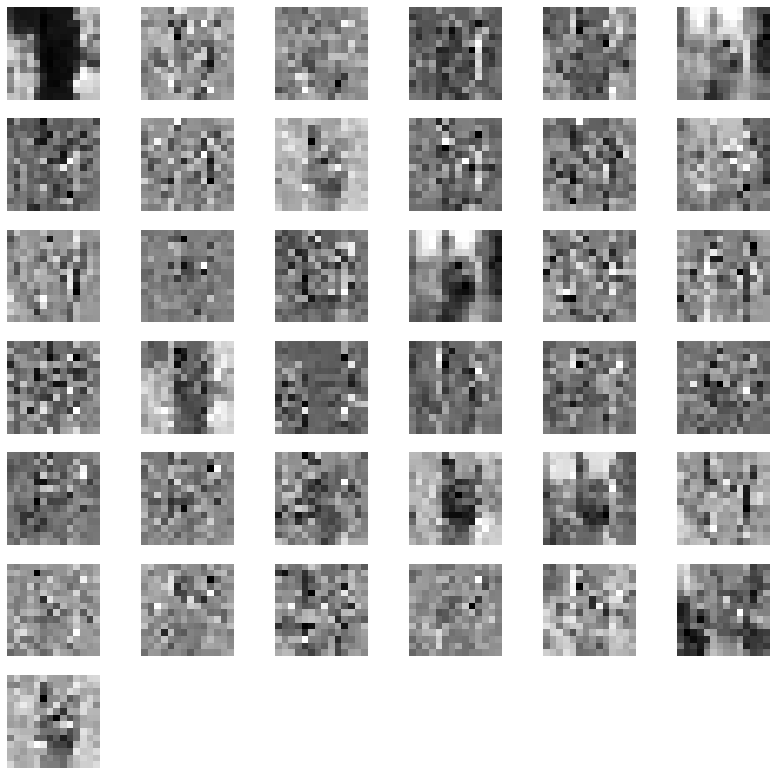

Saving layer 2 feature maps...


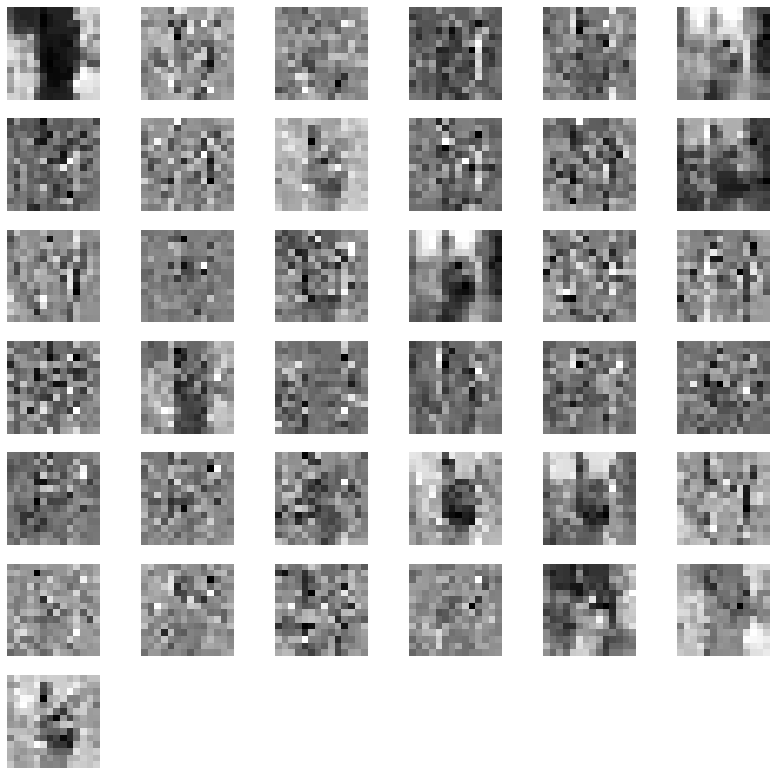

Saving layer 3 feature maps...


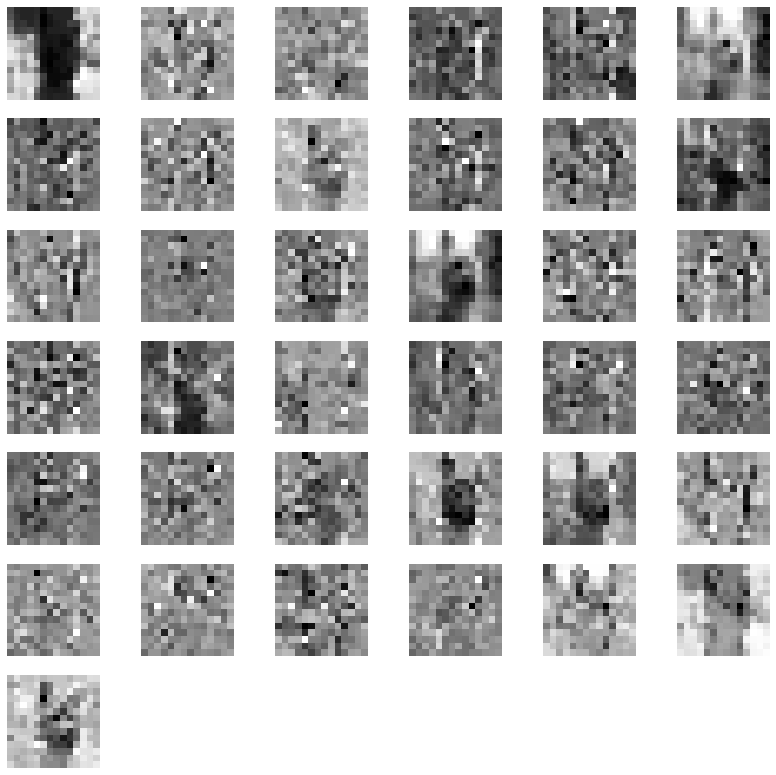

Saving layer 4 feature maps...


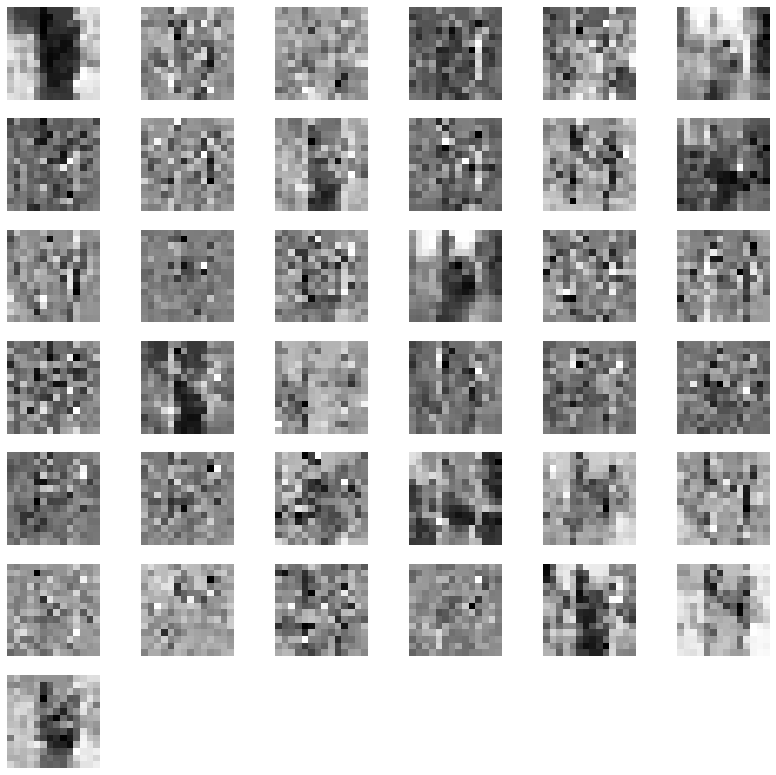

In [11]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 5   # change the number of length to control how many layers you want to visualize
head_num = 8
for num_layer in range(all_layers_num): 
    plt.figure(figsize=(14, 14))
    layer_viz = tea_outputs[num_layer]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = layer_viz.reshape(384, 14, 14)  # chage the reshape here
    #print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 36: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(7, 6, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    
    channel_attn = layer_viz.mean(0)
    plt.subplot(7, 6, 37)
    plt.imshow(channel_attn, cmap='gray')
    plt.axis("off")
    
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig("./visul_fig/tea_layer_{}.png".format(num_layer))  # change the path to save the feature maps
    plt.show() # use this line to show the figure in jupyter notebook
    plt.close()
    

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 0 feature maps...


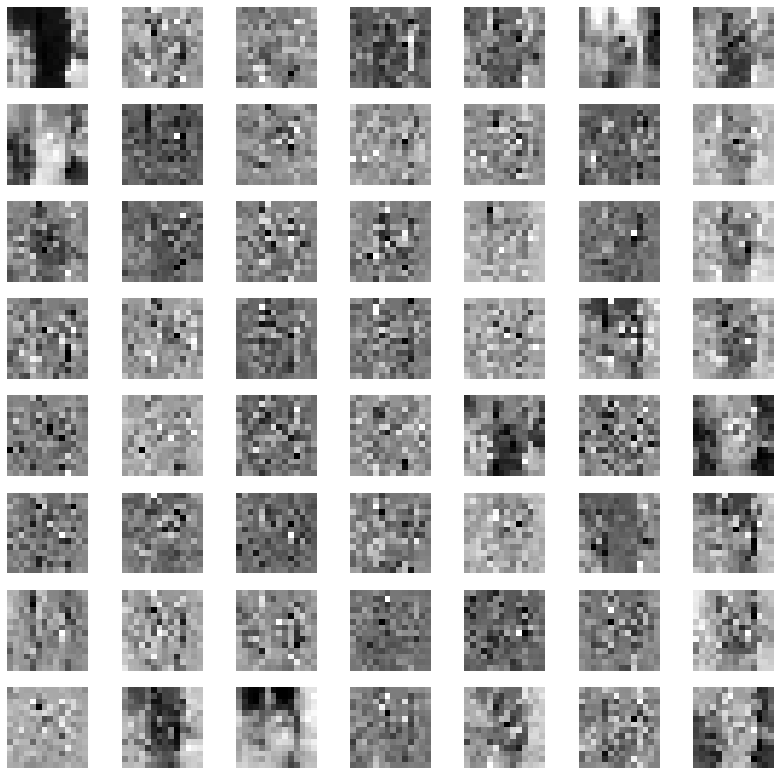

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 1 feature maps...


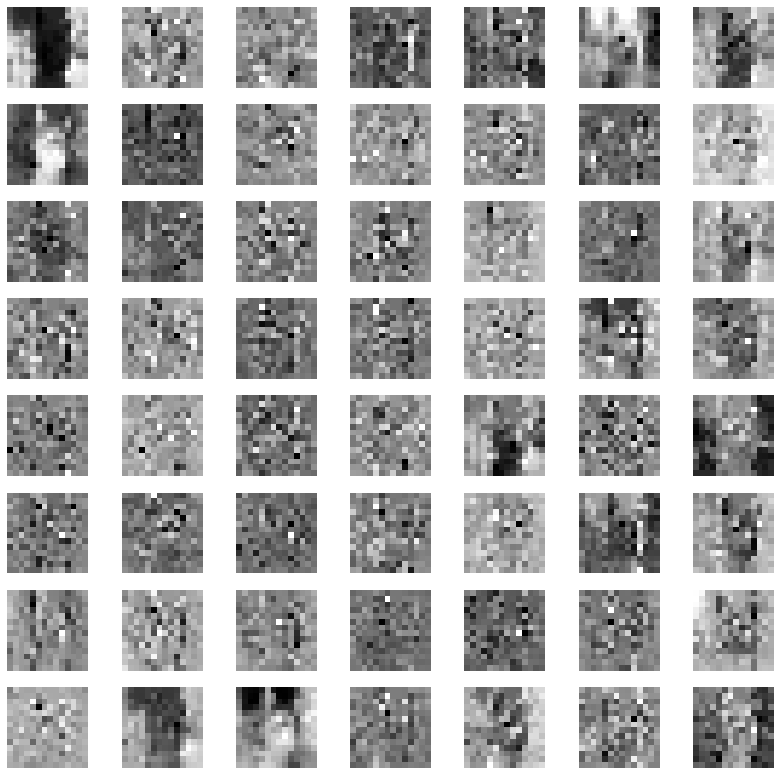

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 2 feature maps...


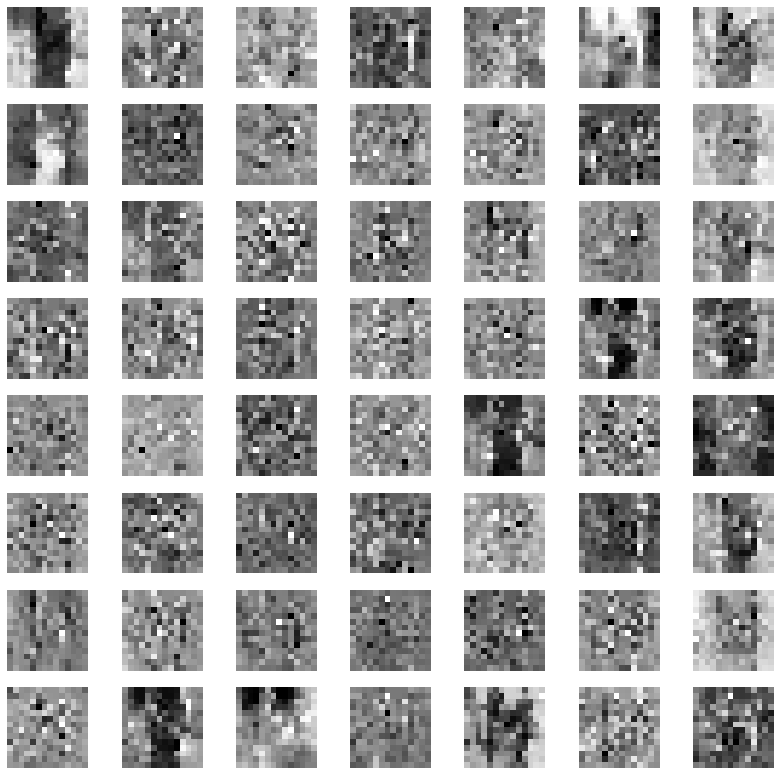

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 3 feature maps...


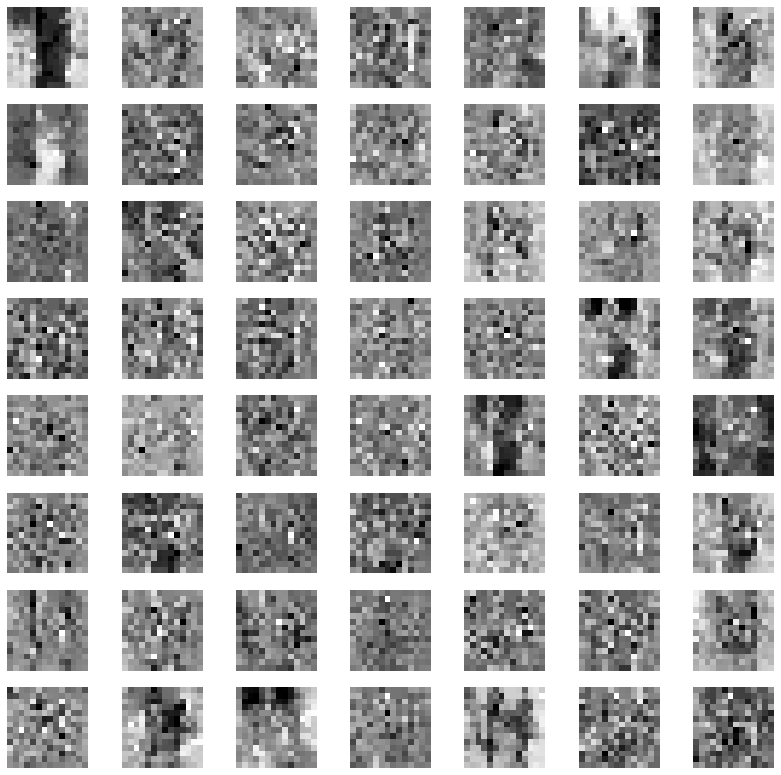

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 4 feature maps...


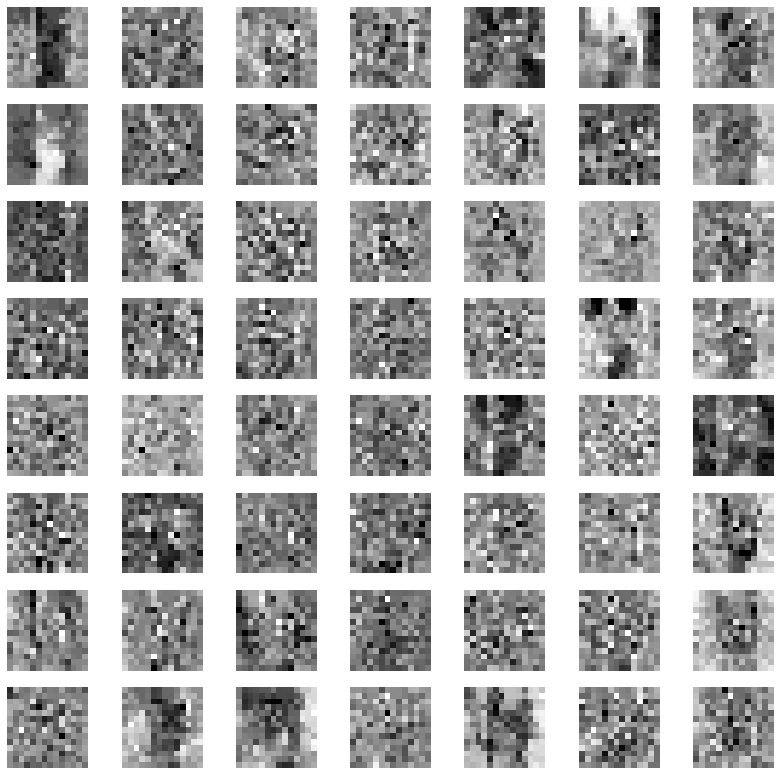

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 5 feature maps...


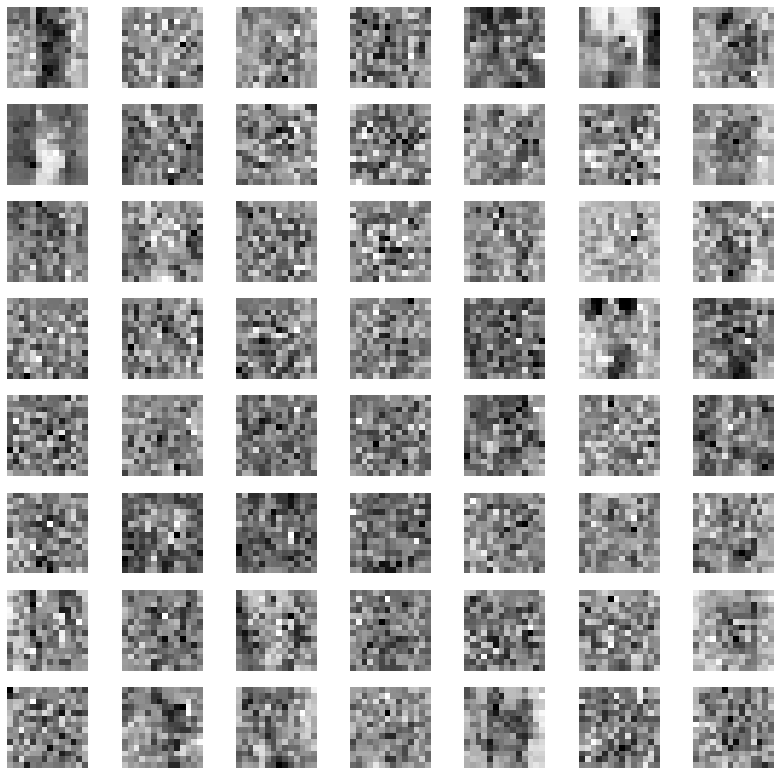

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 6 feature maps...


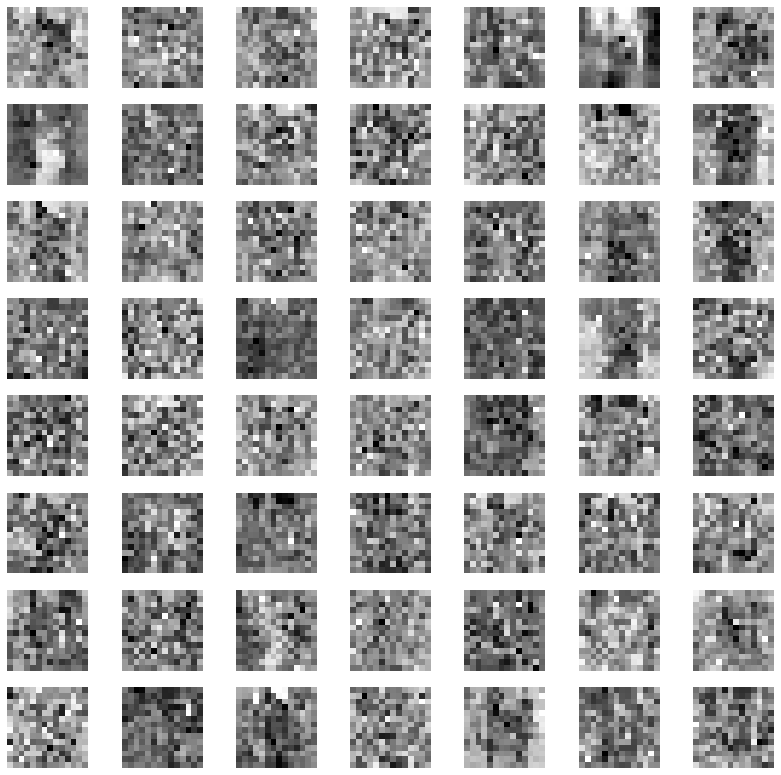

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 7 feature maps...


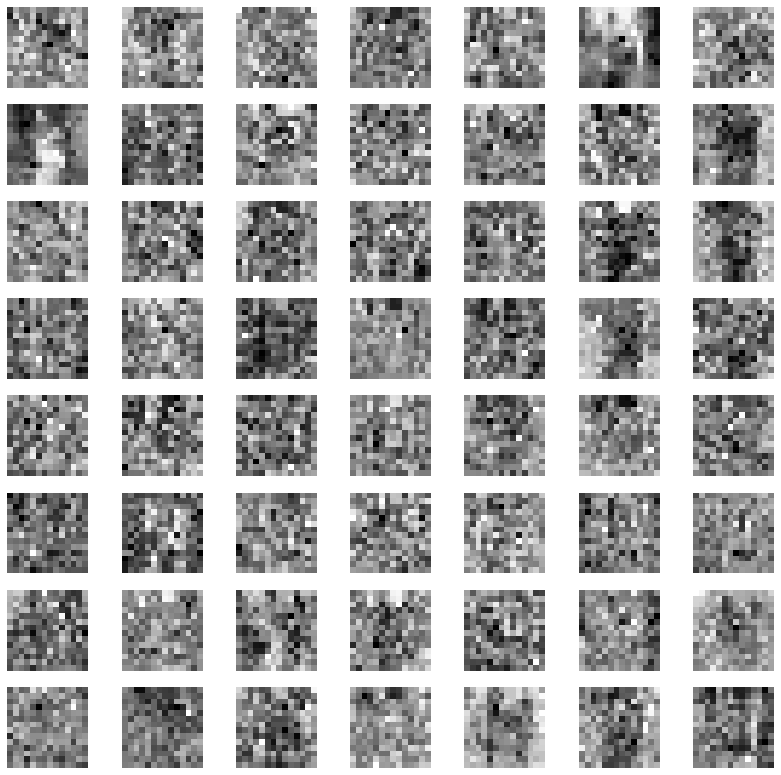

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 8 feature maps...


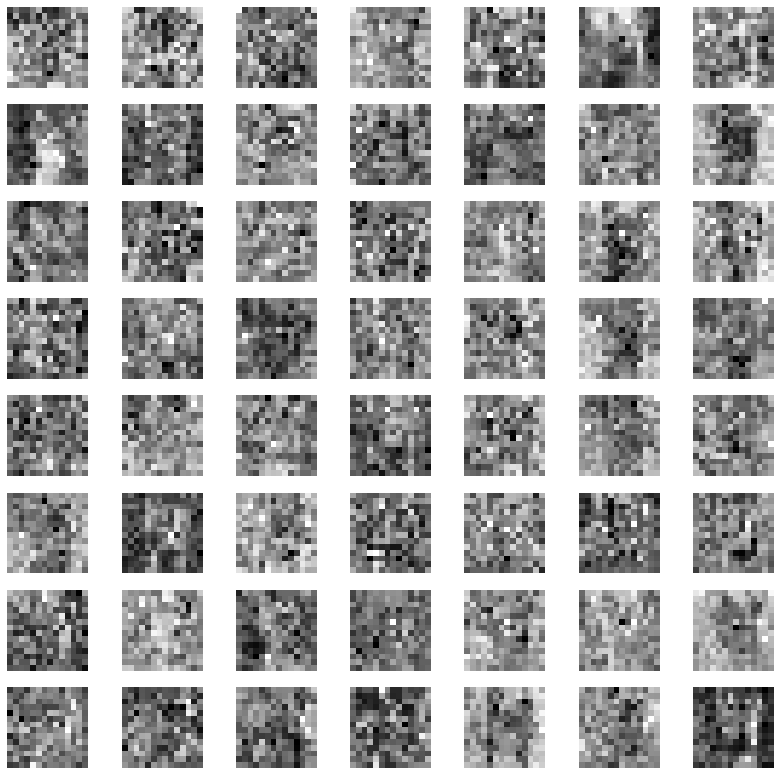

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 9 feature maps...


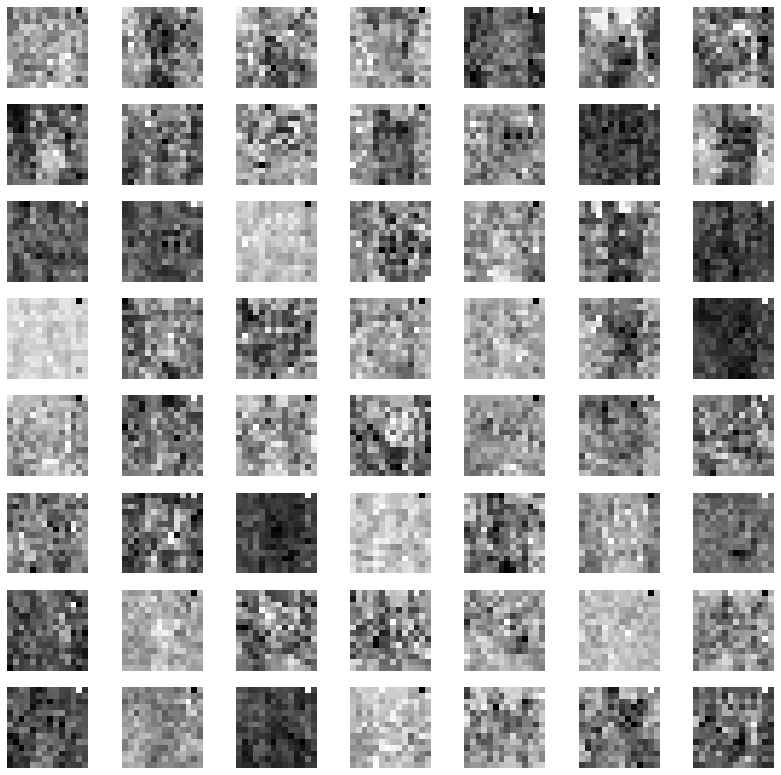

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 10 feature maps...


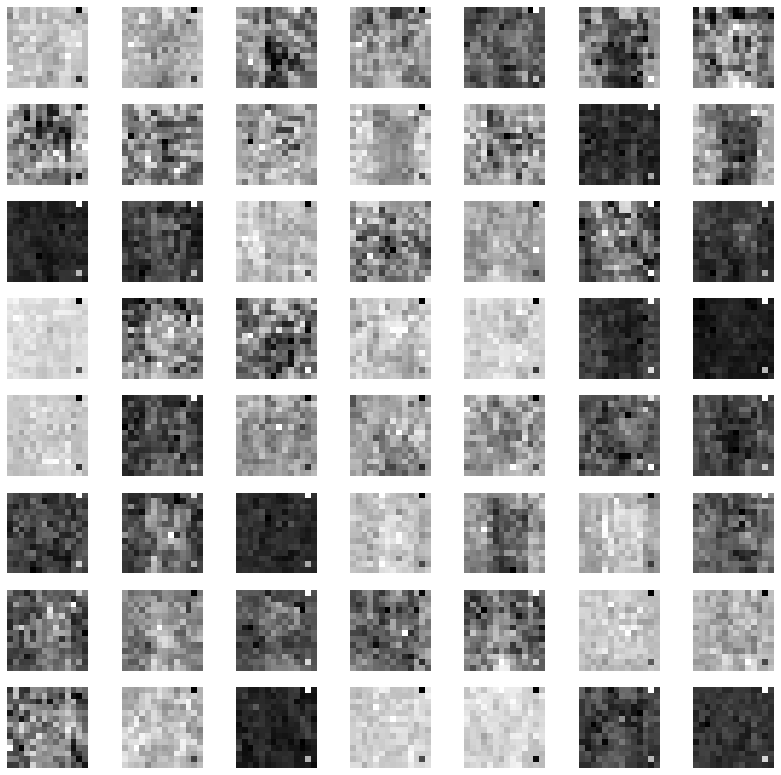

torch.Size([8, 14, 14])
torch.Size([384, 14, 14])
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
1 0 48
1 1 49
1 2 50
1 3 51
1 4 52
1 5 53
2 0 96
2 1 97
2 2 98
2 3 99
2 4 100
2 5 101
3 0 144
3 1 145
3 2 146
3 3 147
3 4 148
3 5 149
4 0 192
4 1 193
4 2 194
4 3 195
4 4 196
4 5 197
5 0 240
5 1 241
5 2 242
5 3 243
5 4 244
5 5 245
6 0 288
6 1 289
6 2 290
6 3 291
6 4 292
6 5 293
7 0 336
7 1 337
7 2 338
7 3 339
7 4 340
7 5 341
Saving layer 11 feature maps...


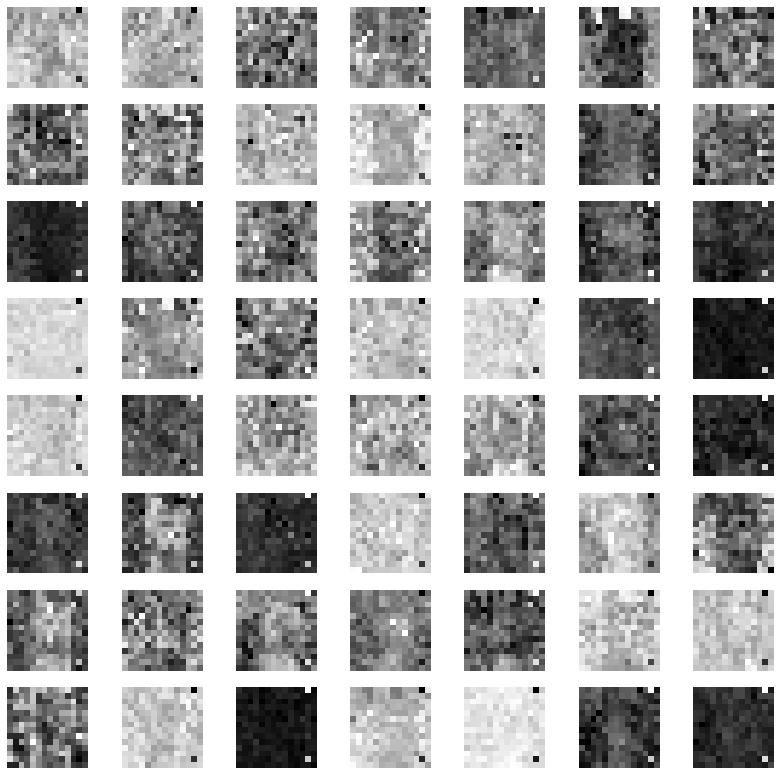

In [45]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 12   # change the number of length to control how many layers you want to visualize
head_num = 8
head_dim = 48
for num_layer in range(all_layers_num): 
    plt.figure(figsize=(14, 14))
    layer_viz = tea_outputs[num_layer*2 + 1]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = layer_viz.reshape(384, 14, 14)  # chage the reshape here
    channel_attn = layer_viz.reshape(head_num, 384//head_num, 14, 14)
    channel_attn = channel_attn.mean(1)
    print(channel_attn.size())
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 384: # we will visualize only 8x8 blocks from each layer
            break
        j = int(i//head_dim)
        k = i % head_dim
#         print(j,k,i)
        if k < 6:
            print(j,k,i)
            plt.subplot(8, 7, j*7+k+1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
            if k==5:
                head_attn = channel_attn[j]
                plt.subplot(8, 7, (j+1)*7)
                plt.imshow(head_attn, cmap='gray')
                plt.axis("off")

#     plt.subplot(7, 6, 37)
#     plt.imshow(channel_attn, cmap='gray')
#     plt.axis("off")
    
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig("./visul_fig/tea_layer_{}.png".format(num_layer))  # change the path to save the feature maps
    plt.show() # use this line to show the figure in jupyter notebook
    plt.close()

Saving layer 0 feature maps...
Saving layer 1 feature maps...
Saving layer 2 feature maps...
Saving layer 3 feature maps...
Saving layer 4 feature maps...
Saving layer 5 feature maps...
Saving layer 6 feature maps...
Saving layer 7 feature maps...
Saving layer 8 feature maps...
Saving layer 9 feature maps...
Saving layer 10 feature maps...
Saving layer 11 feature maps...


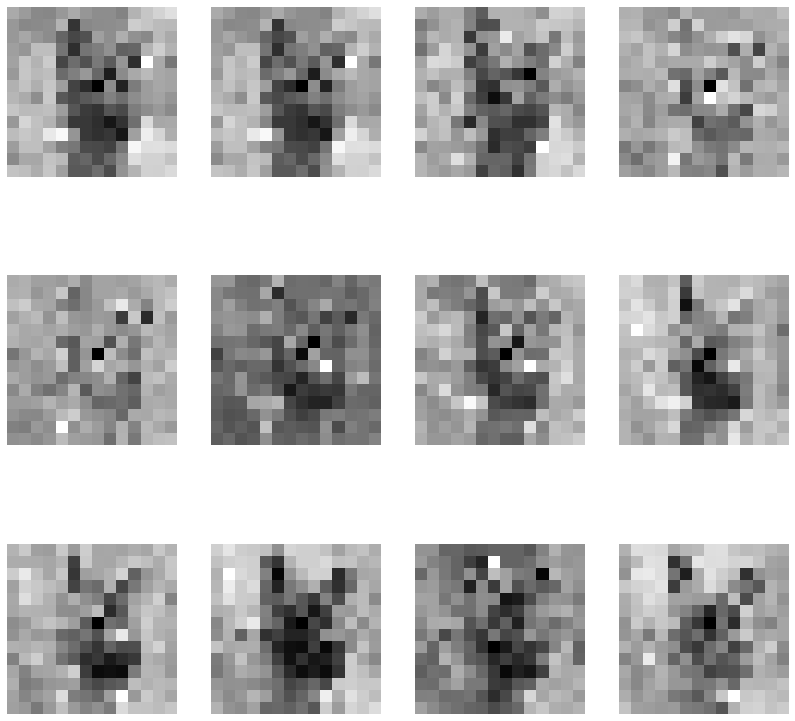

In [17]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 12   # change the number of length to control how many layers you want to visualize
head_num = 3
plt.figure(figsize=(14, 14))
for num_layer in range(all_layers_num): 
#     plt.figure(figsize=(14, 14))
    layer_viz = stu_outputs[num_layer]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = torch.nn.functional.normalize(layer_viz,dim=1)
    layer_viz = layer_viz.reshape(192, 14, 14)  # chage the reshape here
#     layer_viz = layer_viz.view(head_num, 192//head_num, 14, 14)
    channel_attn = layer_viz.mean(0)
#     #print(layer_viz.size())
#     for i, filter in enumerate(layer_viz):
# #         if i == 36: # we will visualize only 8x8 blocks from each layer
# #             break
#         plt.subplot(13, 16, i + 1)
#         plt.imshow(filter, cmap='gray')
#         plt.axis("off")
    plt.subplot(3, 4, num_layer+1)
    plt.imshow(channel_attn, cmap='gray')
    plt.axis("off")
    
    print(f"Saving layer {num_layer} feature maps...")
plt.savefig("./visul_fig/stu_attn.png")  # change the path to save the feature maps
plt.show() # use this line to show the figure in jupyter notebook
plt.close()

tensor([[ 3.6586e-03,  7.2321e-03,  2.2243e-03,  1.9412e-03,  2.2511e-03,
          6.5773e-03,  1.9997e-03,  2.7778e-03,  2.7411e-03,  2.0207e-03,
          8.9402e-03,  6.9214e-03,  9.9257e-03,  8.5334e-03],
        [ 3.4654e-03,  1.9748e-03,  2.8908e-03,  2.7778e-03,  5.0501e-03,
         -4.7780e-03, -9.8140e-05,  2.7281e-03,  2.7778e-03,  3.8154e-03,
          1.2323e-02,  8.5284e-03,  6.2650e-03,  8.0267e-03],
        [ 5.5536e-03,  9.3266e-03,  4.5497e-03,  2.8224e-03,  3.8557e-03,
         -4.9448e-03,  5.9570e-04,  4.9210e-03,  3.6457e-03,  7.3700e-03,
          6.1063e-03,  6.3297e-03,  5.2566e-03,  4.9745e-03],
        [ 7.1511e-03,  5.5923e-03,  6.8305e-03,  7.0967e-03,  2.9882e-03,
         -9.9626e-03, -5.8004e-04,  3.7825e-04,  2.8545e-03, -3.3060e-03,
         -8.9577e-04,  8.2192e-03,  9.4025e-03,  5.6868e-03],
        [ 6.7003e-03,  8.8277e-03,  1.0133e-02,  9.1404e-03,  1.2458e-03,
         -3.0534e-03, -6.1219e-05,  7.5715e-03, -2.0080e-03,  2.0609e-03,
         -2.

tensor([[ 0.0078,  0.0129,  0.0052,  0.0047,  0.0069,  0.0096,  0.0062,  0.0062,
          0.0061,  0.0045,  0.0146,  0.0151,  0.0192,  0.0191],
        [ 0.0078,  0.0033,  0.0069,  0.0062,  0.0083, -0.0057,  0.0014,  0.0062,
          0.0062,  0.0060,  0.0186,  0.0157,  0.0149,  0.0171],
        [ 0.0102,  0.0163,  0.0091,  0.0063,  0.0064, -0.0043,  0.0001,  0.0087,
          0.0076,  0.0137,  0.0101,  0.0109,  0.0132,  0.0122],
        [ 0.0122,  0.0090,  0.0120,  0.0122,  0.0084, -0.0121,  0.0041,  0.0044,
          0.0095, -0.0004,  0.0001,  0.0109,  0.0188,  0.0133],
        [ 0.0130,  0.0158,  0.0178,  0.0165,  0.0061, -0.0025,  0.0002,  0.0131,
         -0.0001,  0.0052, -0.0008,  0.0208,  0.0162,  0.0070],
        [ 0.0138,  0.0161,  0.0144,  0.0141,  0.0072,  0.0030,  0.0092,  0.0017,
         -0.0072,  0.0026,  0.0074,  0.0143,  0.0121,  0.0139],
        [ 0.0128,  0.0114,  0.0104,  0.0140,  0.0128, -0.0018, -0.0050, -0.0145,
          0.0014, -0.0047,  0.0008,  0.0113,  0.0

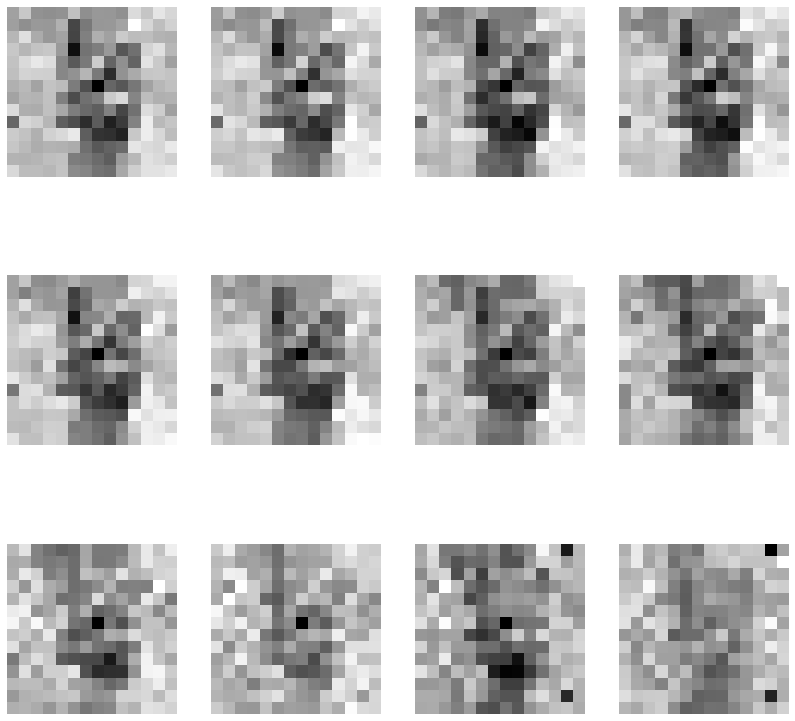

In [19]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 12   # change the number of length to control how many layers you want to visualize
head_num = 3
plt.figure(figsize=(14, 14))
for num_layer in range(all_layers_num): 
#     plt.figure(figsize=(14, 14))
    layer_viz = tea_outputs[num_layer*2+1]#[0, :, :, :]
    layer_viz = layer_viz.data
    layer_viz = layer_viz.squeeze(0).transpose(0, 1)
    layer_viz = torch.nn.functional.normalize(layer_viz,dim=1)
    layer_viz = layer_viz.reshape(384, 14, 14)  # chage the reshape here
#     layer_viz = layer_viz.view(head_num, 192//head_num, 14, 14)
    channel_attn = layer_viz.mean(0)
#     #print(layer_viz.size())
#     for i, filter in enumerate(layer_viz):
# #         if i == 36: # we will visualize only 8x8 blocks from each layer
# #             break
#         plt.subplot(13, 16, i + 1)
#         plt.imshow(filter, cmap='gray')
#         plt.axis("off")
    plt.subplot(3, 4, num_layer+1)
    print(channel_attn)
    plt.imshow(channel_attn, cmap='gray')
    plt.axis("off")
    
    print(f"Saving layer {num_layer} feature maps...")
plt.savefig("./visul_fig/tea_attn.png")  # change the path to save the feature maps
plt.show() # use this line to show the figure in jupyter notebook
plt.close()